In [1]:
from __future__ import division, print_function
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import pylab as plt
import datetime as dt
from datetime import datetime as ddt, date, time
import math
import statsmodels.api as sm

import seaborn as sns
%pylab inline

from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

#from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import os
from tqdm import  tqdm #tnrange, tqdm_notebook as

from numba import jit
from multiprocessing.dummy import Pool as ThreadPool

Populating the interactive namespace from numpy and matplotlib


In [2]:
#сохраняем, чтобы потом не париться, пропустить - если не надо сохранять 
#df.to_csv('data\\df.csv',index_label = 'ind')


In [3]:
#тестовое - потом удалить
#xl= pd.ExcelFile('data/cache/test2.xlsx')
#df = xl.parse('Лист1')
#cols_ND = ['Отдел', 'Зак_Блок', 'Зак_менеджер', 'Прогноз/Факт','Зак_стр_п', 'Подписант КЗ', 'Работа в Sbergile','Согласование аккаунт-менеджера',
#      'Справочник типа заказа','Статус акта по этапу','Статус проекта в портфеле Банка для КЗ',
#      'Статус уточненного этапа СП','Тип КЗ','Тип СП','Тип договора','Тип затрат',
#      'Тип командировки (Зарубежная /По России)','Уточенный номер СП','Уточненный номер этапа СП',
#      'Уточненный тип СП','Уточненный тип договора ']
#for field in cols_ND: 
#    df[field].fillna('#nd',inplace=True)


In [4]:
#загружаем данные 
#df= pd.read_csv('data\\df.csv',index_col = 'ind', parse_dates=True, encoding='1251') 
#df.head(5)

#раскомментировать если работаем с тем, что раньше грузили
xl = pd.ExcelFile('data/cache/pre_df_u2_1.xlsx')
pre_df2 = xl.parse('Sheet1')
xl = pd.ExcelFile('data/cache/pre_df_u_1.xlsx')
pre_df = xl.parse('Sheet1')
xl= pd.ExcelFile('data/cache/df_g.xlsx')
df = xl.parse('Sheet1')

#сверки того, что всё загрузилось и склеилось корректно
print(pre_df['Итого стоимость работ (руб.)'].sum())
print(df['Итого стоимость работ (руб.)'].sum())
print(pre_df['ч/д_факт'].sum())
print(df['ч/д_факт'].sum())
print(pre_df['Дл раб факт'].sum())
print(df['Дл раб факт'].sum())

print(pre_df2['Стоимость (руб)'].sum())
print(df['Стоимость (руб)'].sum())
print(pre_df2['Дл раб план'].sum())
print(df['Дл раб план'].sum())
print(pre_df2['ч/д_план'].sum())
print(df['ч/д_план'].sum())
#print(df.columns)

!telegram-send 'таблицы_загружены'

49963570937.0
49963570937.0
3399364.395
3399364.395
120131339
120131339.0
58930636893.0
58930636893.0
103577076
103577076.0
3916309.32492
3916309.32492


In [17]:
limDate = dt.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-3)*3, 30)
print(limDate)
#помечаем те платежи, которые надо оценивать статусом 2 если плановая дата не сильно стара
df['Статус']=df.apply(lambda r: 2 if ((r['Статус']==0)&(pd.to_datetime(r['Дата окончания'])<=limDate)) else r['Статус'], axis=1)
df['ГО_план'] = df.apply(lambda r: pd.to_datetime(r['Дата окончания']).year, axis=1)
df['КО_план'] = df.apply(lambda r: pd.to_datetime(r['Дата окончания']).quarter , axis=1)
df['ГН_план'] = df.apply(lambda r: pd.to_datetime(r['Дата начала']).year, axis=1)
df['КН_план'] = df.apply(lambda r: pd.to_datetime(r['Дата начала']).quarter , axis=1)
#признак квартала планового окончания
df["KO_Q1"] = df['КО_план'].apply(lambda x: 1 if x==1 else 0)
df["KO_Q2"] = df['КО_план'].apply(lambda x: 1 if x==2 else 0)
df["KO_Q3"] = df['КО_план'].apply(lambda x: 1 if x==3 else 0)
df["KO_Q4"] = df['КО_план'].apply(lambda x: 1 if x==4 else 0)
#признак квартала планового начала
df["KН_Q1"] = df['КН_план'].apply(lambda x: 1 if x==1 else 0)
df["KН_Q2"] = df['КН_план'].apply(lambda x: 1 if x==2 else 0)
df["KН_Q3"] = df['КН_план'].apply(lambda x: 1 if x==3 else 0)
df["KН_Q4"] = df['КН_план'].apply(lambda x: 1 if x==4 else 0)
#признак года планового окончания
df["ГO_2013"] = df['ГО_план'].apply(lambda x: 1 if x==2013 else 0)
df["ГO_2014"] = df['ГО_план'].apply(lambda x: 1 if x==2014 else 0)
df["ГO_2015"] = df['ГО_план'].apply(lambda x: 1 if x==2015 else 0)
df["ГO_2016"] = df['ГО_план'].apply(lambda x: 1 if x==2016 else 0)
df["ГO_2017"] = df['ГО_план'].apply(lambda x: 1 if x==2017 else 0)
df["ГO_2018"] = df['ГО_план'].apply(lambda x: 1 if x==2018 else 0)
df["ГO_2019"] = df['ГО_план'].apply(lambda x: 1 if x==2019 else 0)
df["ГO_2020"] = df['ГО_план'].apply(lambda x: 1 if x==2020 else 0)
df["ГO_2021"] = df['ГО_план'].apply(lambda x: 1 if x==2021 else 0)
df["ГO_2022"] = df['ГО_план'].apply(lambda x: 1 if x==2022 else 0)
#признак квартала планового начала
df["ГН_2013"] = df['ГН_план'].apply(lambda x: 1 if x==2013 else 0)
df["ГН_2014"] = df['ГН_план'].apply(lambda x: 1 if x==2014 else 0)
df["ГН_2015"] = df['ГН_план'].apply(lambda x: 1 if x==2015 else 0)
df["ГН_2016"] = df['ГН_план'].apply(lambda x: 1 if x==2016 else 0)
df["ГН_2017"] = df['ГН_план'].apply(lambda x: 1 if x==2017 else 0)
df["ГН_2018"] = df['ГН_план'].apply(lambda x: 1 if x==2018 else 0)
df["ГН_2019"] = df['ГН_план'].apply(lambda x: 1 if x==2019 else 0)
df["ГН_2020"] = df['ГН_план'].apply(lambda x: 1 if x==2020 else 0)
df["ГН_2021"] = df['ГН_план'].apply(lambda x: 1 if x==2021 else 0)
df["ГН_2022"] = df['ГН_план'].apply(lambda x: 1 if x==2022 else 0)

#pd.to_numeric((pd.to_datetime(r['Дата окончания']).month)/3.,errors='ignore', downcast='integer')
#df[df['Статус']==2].head(5)
#print(df[df['Статус']==2].shape)
#print(df[df['Статус']==0].shape)
#print(df[df['Статус']==1].shape)
cols_ND = ['Отдел', 'Зак_Блок', 'Зак_менеджер', 'Прогноз/Факт','Зак_стр_п', 'Подписант КЗ', 'Работа в Sbergile','Согласование аккаунт-менеджера',
      'Справочник типа заказа','Статус акта по этапу','Статус проекта в портфеле Банка для КЗ',
      'Статус уточненного этапа СП','Тип КЗ','Тип СП','Тип договора','Тип затрат',
      'Тип командировки (Зарубежная /По России)','Уточенный номер СП','Уточненный номер этапа СП',
      'Уточненный тип СП','Уточненный тип договора ']
for field in cols_ND: 
    df[field].fillna('#nd',inplace=True)

#df.head(5)

2017-03-30 00:00:00


,ID АРИАДНЫ,ID АС ЦУП,Аккаунт менеджер КЗ,Грейд,Дата начала этапа,Дата окончания этапа,Дата открытия на ООУ,Департамент,Должность,Зак_Блок,...,ГН_2013,ГН_2014,ГН_2015,ГН_2016,ГН_2017,ГН_2018,ГН_2019,ГН_2020,ГН_2021,ГН_2022
0,SBT-000113,99144,Джумаева Ольга Арипжановна.ЦА,11,2014-07-01,2015-07-03,2011-11-24 01:00:00,Департамент проектного управления,Старший руководитель проектов,Розничный бизнес,...,0,0,0,0,0,0,0,0,0,0
1,SBT-000113,99144,Джумаева Ольга Арипжановна.ЦА,11,2014-07-01,2015-07-03,2011-11-24 01:00:00,Департамент проектного управления,Старший руководитель проектов,Розничный бизнес,...,0,0,0,0,0,0,0,0,0,0
2,SBT-000193,233231,Сидоров Владислав Валерьевич,10,2014-08-19,2015-11-30,2014-08-26 01:00:00,Департамент развития фронтальных систем и элек...,Главный инженер,"Программа ""Кибербезопасность 2018"" (КБ2018)",...,0,1,0,0,0,0,0,0,0,0
3,SBT-000193,233231,Сидоров Владислав Валерьевич,12,2014-08-19,2015-11-30,2014-08-26 01:00:00,Департамент проектного управления,Главный руководитель проектов,"Программа ""Кибербезопасность 2018"" (КБ2018)",...,0,1,0,0,0,0,0,0,0,0
4,SBT-000193,233231,Сидоров Владислав Валерьевич,10,2014-08-19,2015-11-30,2014-08-26 01:00:00,Департамент автоматизации бизнес процессов,Ведущий аналитик,"Программа ""Кибербезопасность 2018"" (КБ2018)",...,0,0,0,0,0,0,0,0,0,0


In [18]:
predictors_res  = ['Плановый процент загрузки', 'Дл раб план', 'Стоимость (руб)',
       'ч/д_план', 'Подписант КЗ', 'Аккаунт менеджер КЗ', 'Менеджер (КЗ)',
       'Дата открытия на ООУ', 'Статус проекта в портфеле Банка для КЗ',
       'Наличие СП', 'Уточненный тип договора ', 'Уточненный тип СП',
       'Статус акта по этапу', 'Зак_Блок', 'Зак_менеджер', 'Тип КЗ','ФИО',
       'Справочник типа заказа', 'ID АРИАДНЫ', 'Департамент', 'Управление','Отдел','Должность',
       'Согласование аккаунт-менеджера', 'Грейд', 'Прогноз/Факт', 'Работа в Sbergile','Активен',
       'Уточненный номер этапа СП', 'Дл раб факт','Тип командировки (Зарубежная /По России)',
       'Итого стоимость работ (руб.)', 'ч/д_факт', 'Тип СП', 'KO_Q1', 'KO_Q2', 'KO_Q3', 'KO_Q4', 
       'KН_Q1', 'KН_Q2', 'KН_Q3', 'KН_Q4', 'ГO_2013', 'ГO_2014', 'ГO_2015', 'ГO_2016', 'ГO_2017', 'ГO_2018', 'ГO_2019',
       'ГO_2020', 'ГO_2021', 'ГO_2022', 'ГН_2013', 'ГН_2014', 'ГН_2015', 'ГН_2016', 'ГН_2017', 'ГН_2018', 'ГН_2019',
       'ГН_2020', 'ГН_2021', 'ГН_2022']
#выделение обучающей выборки по деньгам срокам и трудозатратам
df_1 = df[df['Статус']==1][predictors_res]
df_1.dropna(inplace=True)

#выделение обучающей выборки по тем планам, по которым не будет оплаты
failPay_cols = predictors_res+['Статус']
failPay_cols.remove('Дл раб факт')
failPay_cols.remove('Итого стоимость работ (руб.)')
failPay_cols.remove('ч/д_факт')
df_failPay = df[((df['Статус']==2)|(df['Статус']==1))][failPay_cols]
#df_failPay.to_excel('data/df_fp.xlsx')
df_failPay.dropna(inplace=True)

cols_f = ['Подписант КЗ', 'Аккаунт менеджер КЗ', 'Менеджер (КЗ)',
       'Статус проекта в портфеле Банка для КЗ',
       'Наличие СП', 'Уточненный тип договора ', 'Уточненный тип СП',
       'Статус акта по этапу', 'Зак_Блок', 'Зак_менеджер', 'Тип КЗ',
       'Справочник типа заказа', 'Департамент', 'Управление','Отдел','Должность','ФИО',
       'Согласование аккаунт-менеджера', 'Прогноз/Факт','Тип СП', 'Работа в Sbergile','Активен',
       'Тип командировки (Зарубежная /По России)']
#

for col in cols_f:
        df_1[col+'_num'] = pd.factorize(df_1[col])[0]
        df_failPay[col+'_num'] = pd.factorize(df_failPay[col])[0]

predictors = []
for col in cols_f:
        predictors.append(col+'_num')

#
predictors = predictors + ['Грейд','Уточненный номер этапа СП','ч/д_план', 'Стоимость (руб)', 'Дл раб план','KO_Q1', 'KO_Q2', 'KO_Q3', 'KO_Q4', 
       'KН_Q1', 'KН_Q2', 'KН_Q3', 'KН_Q4', 'ГO_2013', 'ГO_2014', 'ГO_2015', 'ГO_2016', 'ГO_2017', 'ГO_2018', 'ГO_2019',
       'ГO_2020', 'ГO_2021', 'ГO_2022', 'ГН_2013', 'ГН_2014', 'ГН_2015', 'ГН_2016', 'ГН_2017', 'ГН_2018', 'ГН_2019',
       'ГН_2020', 'ГН_2021', 'ГН_2022']   
        
#print(df_1[df_1['Статус']==0].shape)
#print(predictors)

In [19]:
#print(df_1.shape)
#print(df_failPay.shape)
#print(df_failPay.columns)

In [20]:
#df_1['Заказчик КЗ_num'] = np.log1p(df_1['Заказчик КЗ_num'])
#df_1['Менеджер (КЗ)_num'] = np.log1p(df_1['Менеджер (КЗ)_num'])
#df_1['Тип СП_num'] = np.log1p((df_1['Тип СП_num']))
#df_1['Уточненный номер этапа СП_num'] = np.log1p((df_1['Уточненный номер этапа СП_num']))

#df_1['Статус акта по этапу_num'] = np.log1p(df_1['Статус акта по этапу_num'])
#df_1['Должность_num'] = np.log1p(df_1['Должность_num'])
#df_1['Грейд_num'] = np.log1p(df_1['Грейд_num'])
#df_1['ч/д_план'] = np.log1p(df_1['ч/д_план'])

In [21]:
scaler = StandardScaler()
scaler.fit(df_1[predictors])
scaler.fit(df_failPay[predictors])

results = ['Итого стоимость работ (руб.)','ч/д_факт','Дл раб факт']#, 'коэфф_сроки', 'коэфф_труд','коэфф_деньги']
results_failPay = ['Статус']#

trg = df_1[results]
trg_failPay = df_failPay[results_failPay]

trn = pd.DataFrame(scaler.transform(df_1[predictors]),columns=predictors)
trn_failPay = pd.DataFrame(scaler.transform(df_failPay[predictors]),columns=predictors)

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.3,random_state=17)
Xtrn_failPay, Xtest_failPay, Ytrn_failPay, Ytest_failPay = train_test_split(trn_failPay, trg_failPay, test_size=0.3,random_state=17)

In [22]:
#tmp = {}
#строим случайный лес по срокам
#forest_l = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features ='sqrt',random_state=17)
#forest_l.fit(Xtrn, Ytrn.iloc[:,4])
#tmp['R2_Y%s'%str(1)] = r2_score(Ytest.iloc[:,4], forest_l.predict(Xtest))
#tmp

In [ ]:
tmp = {}
models = {}
pbar = tqdm(total=4)
    
for mod in results:
        forest = RandomForestRegressor(n_estimators=300, n_jobs=-1,  max_features =56,random_state=17)
        forest.fit(Xtrn, Ytrn.loc[:,mod])
        tmp[mod] = r2_score(Ytest.loc[:,mod], forest.predict(Xtest))
        models[mod] =forest
        pbar.update(1)
        #params = {'n_estimators': 2000, 'max_depth': 15, 'min_samples_leaf': 1,'min_samples_split':2,
        #          'subsample': 0.8, 'max_features': 28, 'random_state': 17}
        #booster = GradientBoostingRegressor(**params)
        #booster.fit(Xtrn, Ytrn.loc[:,mod])
        #tmp[mod+' boost'] = r2_score(Ytest.loc[:,mod], booster.predict(Xtest))
        #models[mod+' boost'] =booster
        #pbar.update(1)
        #forest = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=17)
        #forest_params = {'max_depth': range(22,30),'max_features': range(27,28)}
        #forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
        #forest_grid.fit(Xtrn, Ytrn.loc[:,mod])
        #print([forest_grid.best_params_, forest_grid.best_score_])
        #tmp[mod] = r2_score(Ytest.loc[:,mod], forest_grid.predict(Xtest))
        #models[mod] =forest_grid
#print(models)
for mod in results_failPay:
        forest = RandomForestClassifier(n_estimators=300, n_jobs=-1,  max_features =56,random_state=17)
        forest.fit(Xtrn_failPay, Ytrn_failPay.loc[:,mod])
        tmp[mod] = r2_score(Ytest_failPay.loc[:,mod], forest.predict(Xtest_failPay))
        models[mod] =forest
        pbar.update(1)   
#print(models)
pbar.close()
print(tmp)

#!telegram-send 'модель_обучена'


 50%|██████████████████████                      | 2/4 [02:07<02:08, 64.24s/it]

In [24]:
dfClearCols = ['ID АРИАДНЫ', 'ID АС ЦУП', 'Аккаунт менеджер КЗ', 'Грейд',
               'Дата начала этапа', 'Дата окончания этапа', 'Дата открытия на ООУ',
               'Департамент', 'Должность', 'Зак_Блок', 'Зак_менеджер', 'Зак_стр_п',
               'Итого стоимость работ (руб.)', 'Категория', 'Менеджер (КЗ)',
               'Наличие СП', 'Отдел', 'Подписант КЗ', 'Прогноз/Факт',
               'Работа в Sbergile', 'Согласование аккаунт-менеджера',
               'Справочник типа заказа', 'Статус акта по этапу',
               'Статус проекта в портфеле Банка для КЗ', 'Статус уточненного этапа СП',
               'Тип КЗ', 'Тип СП', 'Тип договора', 'Тип затрат',
               'Тип командировки (Зарубежная /По России)', 'ч/д_факт', 'Управление',
               'Уточненный номер этапа СП', 'Уточненный тип СП', 'Уточенный номер СП',
               'Уточненный тип договора ', 'ФИО', 'Дл раб факт', 'key2', 'Активен',
               'Дата начала', 'Дата окончания', 'ч/д_план', 'Стоимость (руб)',
               'Плановый процент загрузки', 'Дл раб план', 'Статус']#, 'коэфф_сроки',
               #'коэфф_труд', 'коэфф_деньги']
df=df[dfClearCols]

In [25]:
dfCols = predictors_res+['Дата начала','Дата окончания','Дата окончания этапа','Статус']
#датасет для предсказаний + заполняем там где не надо предсказывать колонки фактическими данными
df_1 = df[df['Статус']==1][dfCols]
df_2 = df[(df['Статус']==0)&(~pd.isnull(df['Аккаунт менеджер КЗ']))][dfCols]
df_3 = df[(df['Статус']==0)&(pd.isnull(df['Аккаунт менеджер КЗ']))][dfCols]
#print(df_2.columns)
for col in cols_f:
        df_2[col+'_num'] = pd.factorize(df_2[col])[0]
print(df_2.shape)
        
pred_data = pd.DataFrame(scaler.transform(df_2[predictors]),columns=predictors)
#pred_data.to_excel('data/pred_data.xlsx')
#формируем датасет с предсказаниями

colsToDrop = df_2.columns
df_2['Итого стоимость работ (руб.)'+'_pred']= models['Итого стоимость работ (руб.)'].predict(pred_data)
df_2['ч/д_факт'+'_pred']= models['ч/д_факт'].predict(pred_data)
df_2['Дл раб факт'+'_pred']= models['Дл раб факт'].predict(pred_data)
df_2['Статус_pred']= models['Статус'].predict(pred_data)



for mod in results:
    #df_2[mod+'_pred'] = models[mod].predict(pred_data)
    #df_2[mod+'_pred'] = models[mod+' boost'].predict(pred_data)
    df_1[mod+'_pred'] = df_1[mod]
df_1['Статус_pred'] = df_1['Статус']

df_1['Дата окончания этапа_pred'] = df_1['Дата окончания этапа']
df_2['Дата окончания этапа_pred'] = df_2.apply(lambda x: x['Дата начала']
                                               +dt.timedelta(days=x['Дл раб факт_pred']), axis =1)

df_3['Итого стоимость работ (руб.)_pred']= df_3['Стоимость (руб)']
df_3['ч/д_факт_pred']= df_3['ч/д_план']
df_3['Дл раб факт_pred']= df_3['Дл раб план']
df_3['Дата окончания этапа_pred']= df_3['Дата окончания']
df_3['Статус_pred'] = df_3['Статус']
df_2.drop(colsToDrop,inplace=True, axis =1)
df_1.drop(dfCols,inplace=True, axis =1)
df_3.drop(dfCols,inplace=True, axis =1)
#print(df_3.columns)
df_pred = df_1.append([df_2,df_3])

df['ind']=df.index
df_pred['ind']=df_pred.index
df=df.merge(df_pred, how ='left',on='ind')
df_pred.drop('ind',inplace=True, axis =1)
df.drop('ind',inplace=True, axis =1)

#print (df.columns)
df['Дата окончания этапа_pred'].fillna(dt.datetime(1970,1,1),inplace=True)

#подгоняем под дату окончания спецификации
df_align = pd.DataFrame(df.groupby(['ID АРИАДНЫ','Уточенный номер СП'])['Дата окончания этапа_pred'].max()).reset_index()
df['Дата окончания корр_pred']=''
for index, row in df_align.iterrows():
        df.loc[((df['ID АРИАДНЫ']==row['ID АРИАДНЫ'])&
                (df['Уточенный номер СП']==row['Уточенный номер СП'])),'Дата окончания корр_pred'] = row['Дата окончания этапа_pred']

quaterDate = dt.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)
#Снижение ошибок презсказаний в прошлом - в прошлом, искуссвенно, видимо надо предсказывать неуспех задачи, т.е. факт её неоплаты
#df.loc[((df['Статус']==0)&(df['Дата окончания этапа_pred']<quaterDate)),'Итого стоимость работ (руб.)_pred']=0
df.loc[((df['Статус']==2)),'Итого стоимость работ (руб.)_pred']=0
df['Квартал завершения'] = pd.to_datetime(df['Дата окончания этапа_pred']).apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
#df['Квартал завершения_корр'] = pd.to_datetime(df['Дата окончания корр_pred']).apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
df['Месяц завершения'] = pd.to_datetime(df['Дата окончания этапа_pred']).apply(lambda x: str(x.year)+'M'+str(x.month))
#df['Месяц завершения_корр'] = pd.to_datetime(df['Дата окончания корр_pred']).apply(lambda x: str(x.year)+'M'+str(x.month))
                                                                #if (x!=0) else 0.0)
#df['Дата окончания корр_pred'] = df.apply(lambda x: x['Дата окончания этапа_pred'] if ((x['Дата окончания корр_pred']=='')) else x['Дата окончания корр_pred'], axis =1)
#df['Квартал завершения_корр']=''
#df['Квартал завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
#df['Месяц завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))


#df.to_excel('data/df_full.xlsx')

(36067, 65)


In [26]:

#df['Дата окончания корр_pred'] = df.apply(lambda x: x['Дата окончания этапа_pred'] if ((x['Дата окончания корр_pred']=='')) else x['Дата окончания корр_pred'], axis =1)
#df['Квартал завершения_корр_pred']=''
#df['Квартал завершения_корр_pred'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
#df['Месяц завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))
#df['Месяц завершения_корр']
#df['Квартал окончания корр_pred'] = df.apply(lambda x: 1 if (x['Дата окончания корр_pred']=='') else 0)
#df['Дата окончания этапа_pred']
#df['Квартал завершения корр_pred']
#df['Дата окончания корр_pred']
#print (type(datetime.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)))
#quaterDate = dt.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)
#df[(df['Дата окончания этапа_pred']<quaterDate)]

In [27]:
#df['Дата окончания корр_pred']

In [28]:
#прогноз загрузки в agile
#посчитаем сколько каждый человек списывается в среднем за квартал
colsST2 = ['Управление','ФИО','Грейд','Категория']#,'Работа в Sbergile'
groupCols = colsST2
df_st2 = pd.DataFrame(df.groupby(groupCols)['Дл раб факт_pred','ч/д_факт_pred','Итого стоимость работ (руб.)_pred'].sum()).reset_index()
df_st2 = df_st2[df_st2['Категория']=='B']
df_st2['ставка_корр'] = df_st2['Итого стоимость работ (руб.)_pred']/df_st2['ч/д_факт_pred']
df_st2['ставка_дн'] = df_st2['Итого стоимость работ (руб.)_pred']/df_st2['Дл раб факт_pred']
df_st2['дн_труд'] = df_st2['Дл раб факт_pred']/df_st2['ч/д_факт_pred']
df_st2['расходы_кв'] = 91 * df_st2['ставка_дн'] 
df_st2['труд_кв'] = 91 * df_st2['дн_труд']
#df_st2.head(5)


In [29]:
#смотрим кто хоть раз в прошедшем периоде работал в agile
colsAge = ['Управление','ФИО','Грейд','Категория','Работа в Sbergile']
groupCols = colsAge
df_age = pd.DataFrame(df.groupby(groupCols)['Дата окончания этапа_pred'].max()).reset_index()
df_age = df_age[(df_age['Работа в Sbergile']!='#nd')&(df_age['Категория']=='B')]#
#df_age.set_index(['Управление','ФИО','Грейд'])
df_age =pd.DataFrame(df_age.set_index(['Управление','ФИО','Грейд'])).reset_index()
#df_age.head(5)

In [30]:
#заполняем синтетическую таблицу для agile где каждому человеку замеченному в agile ставится в соотвествие 
#4 задачи с длиной вквартал и заполняются данными по этому человеку
agileCols = colsAge + ['ч/д_факт_pred','Дата начала','Дата окончания этапа_pred','Итого стоимость работ (руб.)_pred']
rowCount = df_age.shape[0]*4
df_agiled = pd.DataFrame(columns=df.columns, index=np.arange(0, rowCount))
#print(agileCol
itemCount = rowCount//100
pbar = tqdm(total=100)
ind = 0
row_i = 0                         
for index, row in df_age.iterrows():
        for i in [0,1,2,3]: 
        #i=0
            tmp_row = df_st2[(df_st2['Управление']==row['Управление'])&
                         (df_st2['ФИО']==row['ФИО'])&
                         (df_st2['Грейд']==row['Грейд'])]
            qSum = tmp_row['расходы_кв'].values[0]
            qWork = tmp_row['труд_кв'].values[0]
          
            df_agiled.loc[row_i,'Управление'] = row['Управление']
            df_agiled.loc[row_i,'ФИО'] = row['ФИО']
            df_agiled.loc[row_i,'Грейд'] = row['Грейд']
            df_agiled.loc[row_i,'Категория'] = row['Категория']
            df_agiled.loc[row_i,'Работа в Sbergile'] = row['Работа в Sbergile']
            df_agiled.loc[row_i,'ч/д_факт_pred'] = qWork
            df_agiled.loc[row_i,'Дата начала'] = row['Дата окончания этапа_pred']+dt.timedelta(days=i*91)
            df_agiled.loc[row_i,'Дата окончания этапа_pred'] = row['Дата окончания этапа_pred']+dt.timedelta(days=(i+1)*91)
            df_agiled.loc[row_i,'Итого стоимость работ (руб.)_pred'] = qSum
            ind = ind +1
            row_i = row_i + 1
            if (ind == itemCount):
                    ind = 0
                    pbar.update(1)
            
df_agiled['Итого стоимость работ (руб.)_pred'].fillna(0,inplace=True)
df_agiled['Итого стоимость работ (руб.)'].fillna(0,inplace=True)
df_agiled['Стоимость (руб)'].fillna(0,inplace=True)

df_agiled['Квартал завершения_корр'] = df_agiled['Квартал завершения']
df_agiled['Месяц завершения_корр'] = df_agiled['Месяц завершения']

df_agiled['Квартал завершения'] = df_agiled['Дата окончания этапа_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
df_agiled['Месяц завершения'] = df_agiled['Дата окончания этапа_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))
df = df.append(df_agiled,ignore_index=True)
pbar.close()
#print(ind)        
#df_agiled.head(5)

100%|████████████████████████████████████| 100/100 [22:20:09<00:00, 237.87s/it]


In [31]:
#from datetime import datetime, date, time
#df_3.columns
dt.date(ddt.today().year, math.ceil(ddt.today().month/3-2)*3, 30)
#ddt.today().date()
#df['Дата окончания этапа_pred'].head(5)

datetime.date(2017, 6, 30)

In [32]:
#df_fin.columns
dfCols = ['ID АРИАДНЫ',  'Дата начала этапа', 'Дата окончания этапа', 'Дата открытия на ООУ',
          'Итого стоимость работ (руб.)', 'ч/д_факт','Дл раб факт', 'Дата начала', 'Дата окончания', 
          'ч/д_план', 'Стоимость (руб)', 'Плановый процент загрузки', 'Дл раб план', 'Статус',
          'Итого стоимость работ (руб.)_pred', 'ч/д_факт_pred', 'Дл раб факт_pred',   
          'Дата окончания этапа_pred','Квартал завершения', 'Месяц завершения','Квартал завершения_корр',
          'Месяц завершения_корр']
df_fin= df[dfCols]

In [33]:
df_fin.to_excel('data/df_fin.xlsx')
df.to_excel('data/df_full.xlsx')
#получаем сводную таблицу
df_fin_pivot_Q = df_fin.pivot_table(values=['Итого стоимость работ (руб.)','Итого стоимость работ (руб.)_pred','Стоимость (руб)'], index=['Квартал завершения'], aggfunc='sum')
#,'Департамент','Управление'
df_fin_pivot_Q.to_excel('data/df_pivot_Q.xlsx')
df_fin_pivot_M = df_fin.pivot_table(values=['Итого стоимость работ (руб.)','Итого стоимость работ (руб.)_pred','Стоимость (руб)'], index=['Месяц завершения'], aggfunc='sum')
#,'Департамент','Управление'
df_fin_pivot_M.to_excel('data/df_pivot_M.xlsx')

#df_fin.shape
#print(df_fin['Итого стоимость работ (руб.)_pred'].sum())
#print(df_fin['Итого стоимость работ (руб.)'].sum())
#print(df_fin_pivot['Итого стоимость работ (руб.)_pred'].sum())
#print(df_fin_pivot['Итого стоимость работ (руб.)'].sum())
!telegram-send 'прогноз_готов'

In [34]:
#df_fin_pivot_M.loc['2016M1':'2018M12'].plot(kind='bar', rot=45, figsize=(20,12))

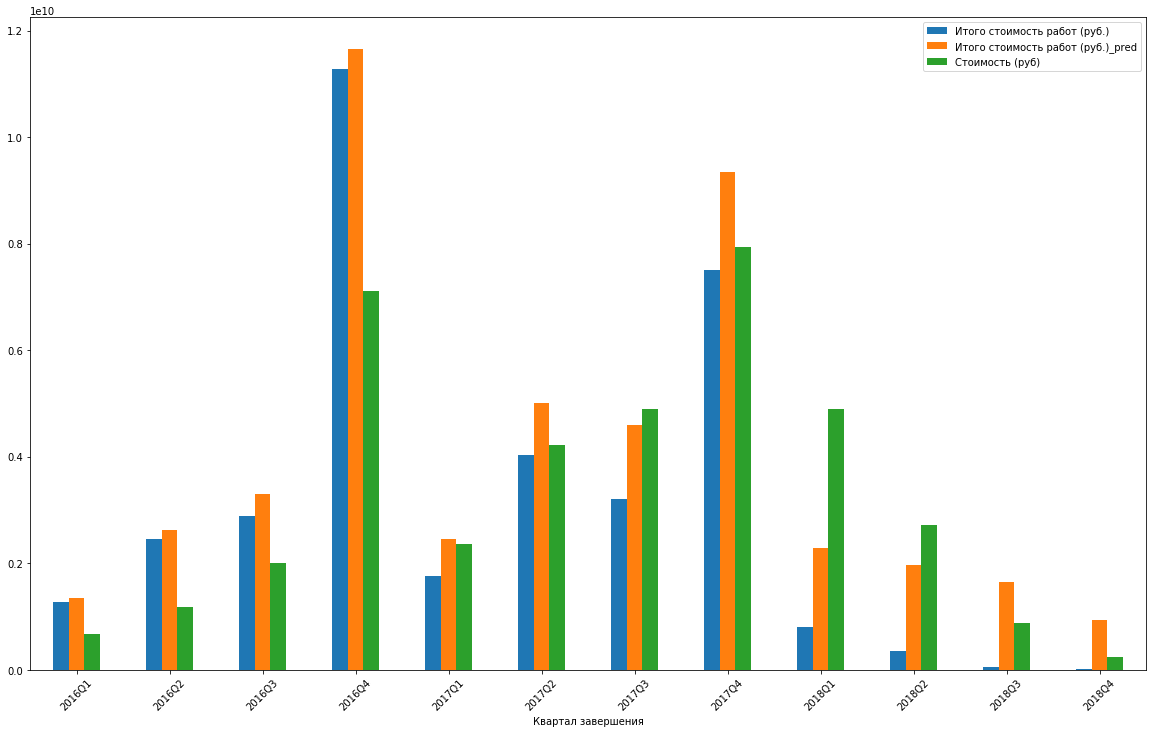

In [35]:
df_fin_pivot_Q.loc['2016Q1':'2018Q4'].plot(kind='bar', rot=45, figsize=(20,12))

In [36]:
df_fin_pivot_M

,Итого стоимость работ (руб.),Итого стоимость работ (руб.)_pred,Стоимость (руб)
Месяц завершения,,,
1970M1,NaN,0.000000e+00,1.337436e+10
1970M10,0.000000e+00,1.505981e+07,0.000000e+00
1970M12,0.000000e+00,1.505981e+07,0.000000e+00
1970M4,0.000000e+00,1.505981e+07,0.000000e+00
1970M7,0.000000e+00,1.505981e+07,0.000000e+00
2013M10,NaN,2.359263e+05,1.449832e+05
2013M11,NaN,2.070382e+06,4.164657e+05
2013M12,NaN,5.215576e+05,1.585196e+05
2013M6,NaN,6.433320e+05,7.959075e+05


In [37]:
df_fin_pivot_Q

,Итого стоимость работ (руб.),Итого стоимость работ (руб.)_pred,Стоимость (руб)
Квартал завершения,,,
1970Q1,NaN,0.000000e+00,1.337436e+10
1970Q2,0.000000e+00,1.505981e+07,0.000000e+00
1970Q3,0.000000e+00,1.505981e+07,0.000000e+00
1970Q4,0.000000e+00,3.011962e+07,0.000000e+00
2013Q2,NaN,6.433320e+05,7.959075e+05
2013Q4,NaN,2.827866e+06,7.199684e+05
2014Q1,NaN,1.190850e+07,7.285680e+06
2014Q2,NaN,2.604041e+07,3.218660e+07
2014Q3,NaN,2.365213e+07,8.891281e+06


In [22]:
#если хотим сохранить и восстановить результаты расчётов
#import pickle as pk

#jar = open('data\\rf.pk', 'wb')
#pk.dump(models, jar) # записать сериализованные данные в jar
#jar.close()

#pkl_file = open('data\\rf.pk', 'rb') # открываем
#models = pickle.load(pkl_file) # сохраняем в переменную
#pkl_file.close()